Installing Required packages

In [1]:
%pip install pandas
%pip install numpy
%pip install gensim
%pip install nltk
%pip install sklearn
%pip install pytrec_eval
import nltk
nltk.download('brown')
nltk.download('stopwords')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\patel\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk.corpus import brown, stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pytrec_eval

C:\Users\patel\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\patel\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\patel\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Importing SimLex-999 Data

In [2]:
data = list()

with open('data\\SimLex-999.txt','r') as rd:
    for l in rd.readlines():
        data.append(l.split('\t'))

In [3]:
df = pd.DataFrame(data[1:], columns=data[0])

In [4]:
df.head()

,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)\n
0,old,new,A,1.58,2.72,2.81,2,7.25,1,0.41\n
1,smart,intelligent,A,9.2,1.75,2.46,1,7.11,1,0.67\n
2,hard,difficult,A,8.77,3.76,2.21,2,5.94,1,1.19\n
3,happy,cheerful,A,9.55,2.56,2.34,1,5.85,1,2.18\n
4,hard,easy,A,0.95,3.76,2.07,2,5.82,1,0.93\n


In [5]:
unique_words = [i for i in df.word1.unique()]
w2_unique = [i for i in df.word2.unique()]
for i in w2_unique:
    if(i not in unique_words):
        unique_words.append(i)

Making dictonary of similar words from gold standard

In [6]:
def similar_word_simlex(word, df):
    sim = dict()
    for j,k in enumerate(df.word1):
        if(word==k):
            sim[df.word2.iloc[j]] = df.SimLex999.iloc[j]
    for j,k in enumerate(df.word2):
        if(word==k):
            sim[df.word1.iloc[j]] = df.SimLex999.iloc[j]
    sim = {k:v for k,v in sorted(sim.items(), key=lambda x:x[1], reverse=True)}
    return [i for i in sim.keys()]

In [7]:
top_10_g = dict()
for i in unique_words:
    top_10_g[i] = similar_word_simlex(i, df)

In [8]:
top_10_g['fast']

['rapid']

In [9]:
for v in top_10_g:
    t = top_10_g[v]
    #keys = [i for i in t.keys()]
    for i in t:
        new = similar_word_simlex(i,df)
    for i in new:
        if(i not in t):
            if(i != v):
                t.append(i)
    while(len(t)>10):
        t.pop(-1)

In [10]:
for w in top_10_g.keys():
    top_10_g[w] = {x:1 for x in top_10_g[w]}

In [11]:
top_10_g

{'old': {'new': 1, 'fresh': 1, 'wide': 1},
 'smart': {'intelligent': 1,
  'dumb': 1,
  'stupid': 1,
  'dense': 1,
  'foolish': 1,
  'clever': 1,
  'rare': 1,
  'huge': 1},
 'hard': {'difficult': 1,
  'tough': 1,
  'dense': 1,
  'simple': 1,
  'easy': 1,
  'flexible': 1,
  'big': 1},
 'happy': {'cheerful': 1,
  'glad': 1,
  'young': 1,
  'angry': 1,
  'mad': 1,
  'unhappy': 1,
  'terrific': 1},
 'fast': {'rapid': 1, 'quick': 1},
 'short': {'long': 1, 'narrow': 1},
 'stupid': {'dumb': 1,
  'dense': 1,
  'foolish': 1,
  'clever': 1,
  'intelligent': 1,
  'smart': 1,
  'rare': 1,
  'huge': 1},
 'weird': {'odd': 1, 'strange': 1, 'normal': 1, 'different': 1},
 'wide': {'narrow': 1, 'fresh': 1, 'new': 1, 'old': 1},
 'bad': {'awful': 1,
  'terrible': 1,
  'immoral': 1,
  'guilty': 1,
  'terrific': 1,
  'great': 1,
  'wonderful': 1},
 'easy': {'simple': 1,
  'flexible': 1,
  'big': 1,
  'hard': 1,
  'difficult': 1,
  'tough': 1,
  'sly': 1},
 'insane': {'crazy': 1, 'sick': 1},
 'large': {'big':

Importing Adventure and Romance Corpus from NLTK Brown Corpus

In [12]:
corpus_adv = brown.sents(categories=['adventure'])
corpus_rom = brown.sents(categories=['romance'])

Using Tf-idf Vectorizer

Preprocessing

In [13]:
def preprocess(corpus):
    text = []
    stop_word = stopwords.words('english')
    for t in corpus:
        t = " ".join(t)
        t = re.sub("[^a-zA-Z]"," ",t)
        t = [w for w in t.split() if w not in stop_word]
        text.append(" ".join(t))
    return text

For Calculating Similarity Score

In [14]:
def similarity_score(text):
    vec = TfidfVectorizer(use_idf=True, ngram_range=(1,1))
    met = vec.fit_transform(text)
    cosine_sim = cosine_similarity(met,met)
    tfidf_word = vec.get_feature_names()
    return cosine_sim, tfidf_word

Finding Similar Words

In [15]:
def find_sim_word(top_10_g, tfidf_word, cosine_sim):
    y = dict()
    for w in top_10_g.keys():
        for i,j in zip(tfidf_word,cosine_sim):
            if(i==w):
                d = {k:v for k,v in zip(tfidf_word,j) if(k!=w)}
                s_result = dict(sorted(d.items(), key=lambda x:x[1], reverse=True))
                s_result = dict(list(s_result.items())[0:10])
                y[w]=s_result
    return y

Calculating MAP and NDCG

In [16]:
def get_map_ndcg(result,top_10_g):
    map = 0
    ndcg = 0
    for word in result.keys():
        qrel = {word:top_10_g[word]}
        run = {word:result[word]}
        eval = pytrec_eval.RelevanceEvaluator(qrel,{'map','ndcg'})
        map = map + eval.evaluate(run)[word]['map']
        ndcg = ndcg + eval.evaluate(run)[word]['ndcg']
    return map, ndcg

In [17]:
text = preprocess(corpus=corpus_rom)
cosine_sim,tfidf_word = similarity_score(text=text)
res = find_sim_word(top_10_g=top_10_g, tfidf_word=tfidf_word, cosine_sim=cosine_sim)
map_r, ndcg_r = get_map_ndcg(result=res, top_10_g=top_10_g)


C:\Users\patel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


C:\Users\patel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


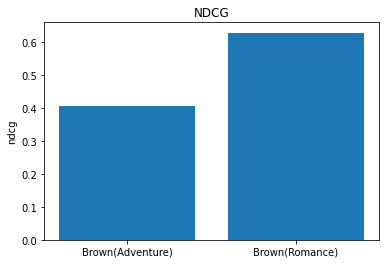

In [18]:
text = preprocess(corpus=corpus_adv)
cosine_sim,tfidf_word = similarity_score(text=text)
res = find_sim_word(top_10_g=top_10_g, tfidf_word=tfidf_word, cosine_sim=cosine_sim)
map_a, ndcg_a = get_map_ndcg(result=res, top_10_g=top_10_g)

import matplotlib.pyplot as plt
height = [ndcg_a,ndcg_r]
x = ['Brown(Adventure)','Brown(Romance)']
plt.bar(x=x, height=height)
plt.ylabel('ndcg')
plt.title("NDCG")
plt.show()

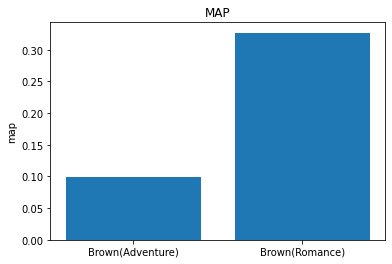

In [19]:
height = [map_a,map_r]
plt.bar(x=x,height=height)
plt.ylabel('map')
plt.title("MAP")
plt.show()

Using Word2Vec Model

In [20]:
def w2v_map_ndcg(windows, vector_size, category, top_10_g):
    ndcg, map = 0,0
    w2v = Word2Vec(sentences=brown.sents(categories=[category]), window=windows, min_count=1, vector_size=vector_size, epochs=1000)
    m,n =0,0
    words = []
    for word in top_10_g.keys():
        if(word in w2v.wv.key_to_index):
            words.append(word)
    for word in words:
        sims = {}
        for s in w2v.wv.most_similar(word,topn=10):
            sims[s[0]] = s[1]
        qrel = {word:top_10_g[word]}
        run = {word:sims}
        eval = pytrec_eval.RelevanceEvaluator(qrel, {'map','ndcg'})
        m = m + eval.evaluate(run)[word]['map']
        n = n + eval.evaluate(run)[word]['ndcg']
    return n, m

For Adventure Corpus

In [27]:
windows = [1,2,5,10]
vector_size = [10,50,100,300]
ndcg = dict()
map = dict()
for w in windows:
    for v in vector_size:
        ndcg[f'W:{w}, V:{v}'], map[f'W:{w}, V:{v}'] = w2v_map_ndcg(w,v,'adventure', top_10_g)

label = ndcg.keys()

Ploting Graph

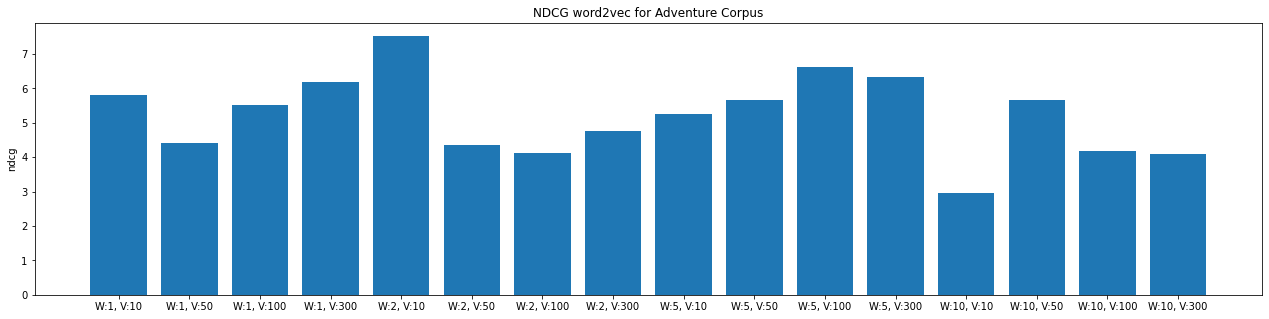

In [28]:
plt.figure(figsize=(22,5))
plt.ylabel('ndcg')
plt.bar(x=label, height=ndcg.values())
plt.title("NDCG word2vec for Adventure Corpus")
plt.show()

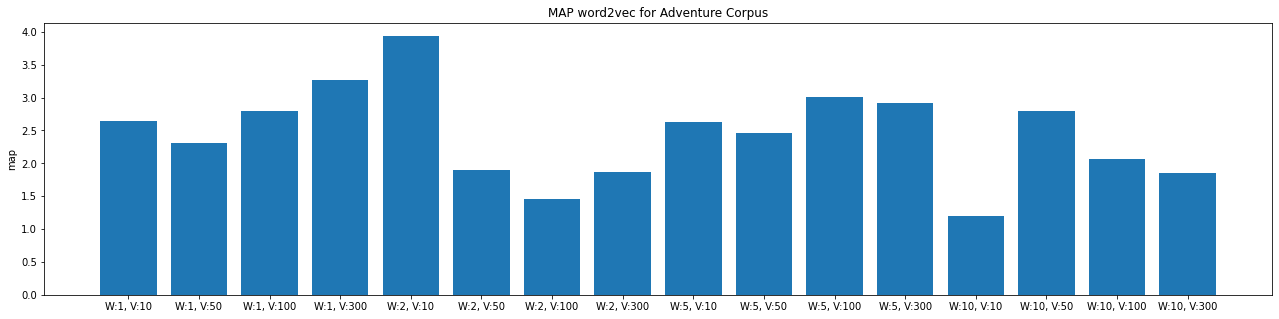

In [29]:
plt.figure(figsize=(22,5))
plt.ylabel('map')
plt.bar(x=label, height=map.values())
plt.title("MAP word2vec for Adventure Corpus")
plt.show()

For Romance Corpus

In [30]:
ndcgr, mapr = dict(), dict()
for w in windows:
    for v in vector_size:
        ndcgr[f'W:{w}, V:{v}'], mapr[f'W:{w}, V:{v}'] = w2v_map_ndcg(w,v,'romance', top_10_g)

Ploting Graphs

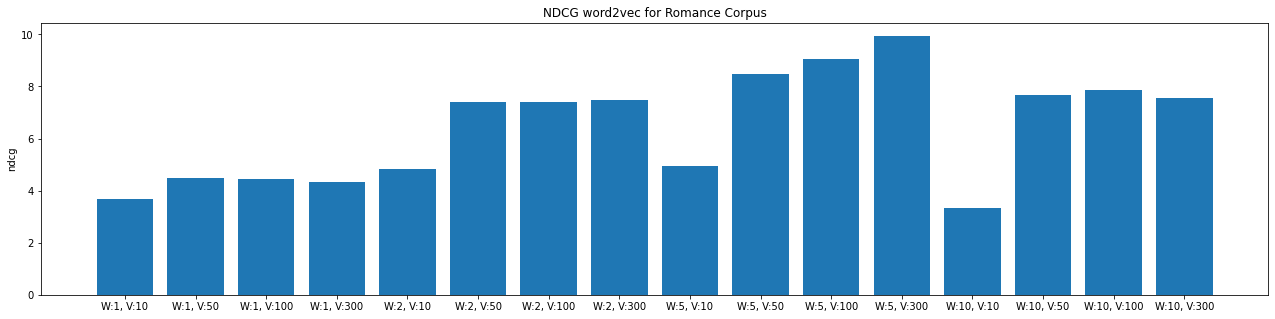

In [31]:
plt.figure(figsize=(22,5))
plt.ylabel('ndcg')
plt.bar(x=label, height=ndcgr.values())
plt.title("NDCG word2vec for Romance Corpus")
plt.show()

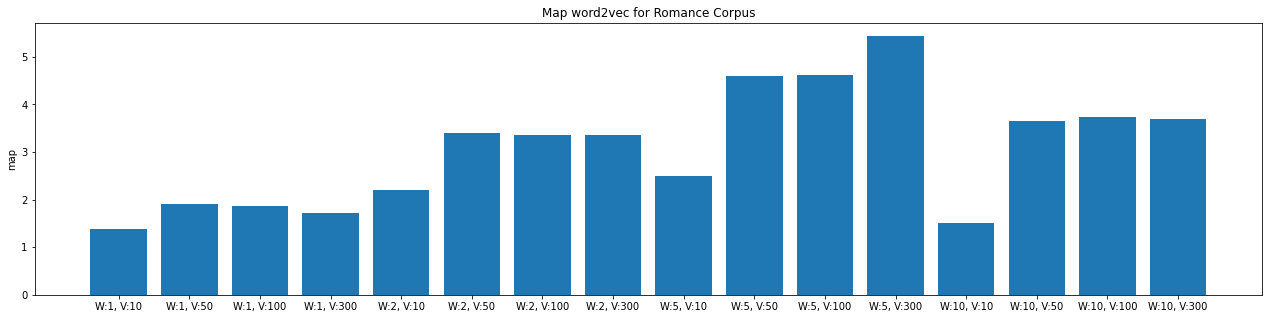

In [32]:
plt.figure(figsize=(22,5))
plt.ylabel('map')
plt.bar(x=label,height=mapr.values())
plt.title("Map word2vec for Romance Corpus")
plt.show()